In [1]:
#setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#definindo a classe para amostragem da distribuição latente z
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2 #dimensão latente

In [4]:
#encoder
#definindo entrada da rede
encoder_inputs = keras.Input(shape=(64, 64, 3))

#extraindo características da imagem através das camadas convolucionais
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", kernel_initializer='he_normal')(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", kernel_initializer='he_normal')(x)

#tranformando features em vetor
x = layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

#sampling layer para amostragem da distribuição normal com média z_mean e variância z_log_var
z = Sampling()([z_mean, z_log_var])

#criando encoder
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                            

In [5]:
#decoder
latent_inputs = keras.Input(shape=(latent_dim,))

#camada densa com ativação relu
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)

#redimensionando tensor saída
x = layers.Reshape((16, 16, 64))(x)

#camada deconvolucional com ativação relu -> gerar imagem mais próxima à original
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same", kernel_initializer='he_normal')(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", kernel_initializer='he_normal')(x)
#camada deconvolucional final
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same", kernel_initializer='he_normal')(x)

#criando modelo decodificador
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             49152     
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        867 

In [6]:
#definindo a classe VAE
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    #definindo a propriedade metrics que retorna as métricas calculadas
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    #definindo o método de treinamento
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            ) #calculando a perda de reconstrução
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [8]:
#carregando arquivo para colab pra usar a API kaggle
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [9]:
#carregando base de dados 
!kaggle competitions download -c 'dogs-vs-cats'

 99% 800M/812M [00:05<00:00, 233MB/s]
100% 812M/812M [00:05<00:00, 164MB/s]


In [10]:
!unzip dogs-vs-cats

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [11]:
#setup
import zipfile
import os
import random

In [12]:
#extraindo arquivos zipados
train_dir = ("train.zip")
test_dir = ("test1.zip")

import zipfile

with zipfile.ZipFile(train_dir,"r") as z:
    
    z.extractall()

with zipfile.ZipFile(test_dir,"r") as z:
    
    z.extractall()

In [15]:
#listando arquivos na pasta
img = os.listdir('./train')
#criando dataframe
data = pd.DataFrame(img)
#preparando dados de treino para classificação binária
data = data.rename(columns={0:'image'})
data['image'] = data['image'].apply(lambda x: './train/' + x)
data['label'] = data['image'].apply(lambda x: 'cat' if 'cat' in x else 'dog')
data['classe'] = data['image'].apply(lambda x: 1 if 'cat' in x else 0)

data.head()

,image,label,classe
0,./train/cat.4122.jpg,cat,1
1,./train/cat.1560.jpg,cat,1
2,./train/cat.5314.jpg,cat,1
3,./train/dog.11479.jpg,dog,0
4,./train/dog.3515.jpg,dog,0


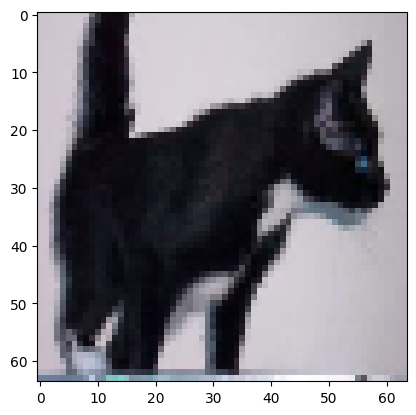

In [16]:
#pré-processando imagens
input_dimensions = (64, 64)
image = []

arq = data['image'].to_list()
for i in arq:
    m = cv2.imread(i)
    m = cv2.resize(m, input_dimensions)
    m = m.astype('float32') / 255
    image.append(m)

plt.imshow(image[1])

#convertendo lista em array numpy
image_np = np.array(image)

In [17]:
#instanciando modelo VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
vae.fit(image_np, epochs=10, batch_size=16)

Epoch 1/10
1563/1563 [==============================] - 27s 8ms/step - loss: 2747.0383 - reconstruction_loss: 2720.0142 - kl_loss: 5.5665
Epoch 2/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2712.6261 - reconstruction_loss: 2707.2812 - kl_loss: 5.0583
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2710.2271 - reconstruction_loss: 2706.3589 - kl_loss: 4.3711
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2711.2256 - reconstruction_loss: 2705.8230 - kl_loss: 4.0002
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2709.2711 - reconstruction_loss: 2705.4048 - kl_loss: 3.6977
Epoch 6/10
1563/1563 [==============================] - 12s 8ms/step - loss: 2708.1694 - reconstruction_loss: 2705.0205 - kl_loss: 3.4664
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 2710.6751 - reconstruction_loss: 2703.8306 - kl_loss: 3.1885
Epoch 8/10
1563/1563 [===========

1/1 [==============================] - 0s 18ms/step


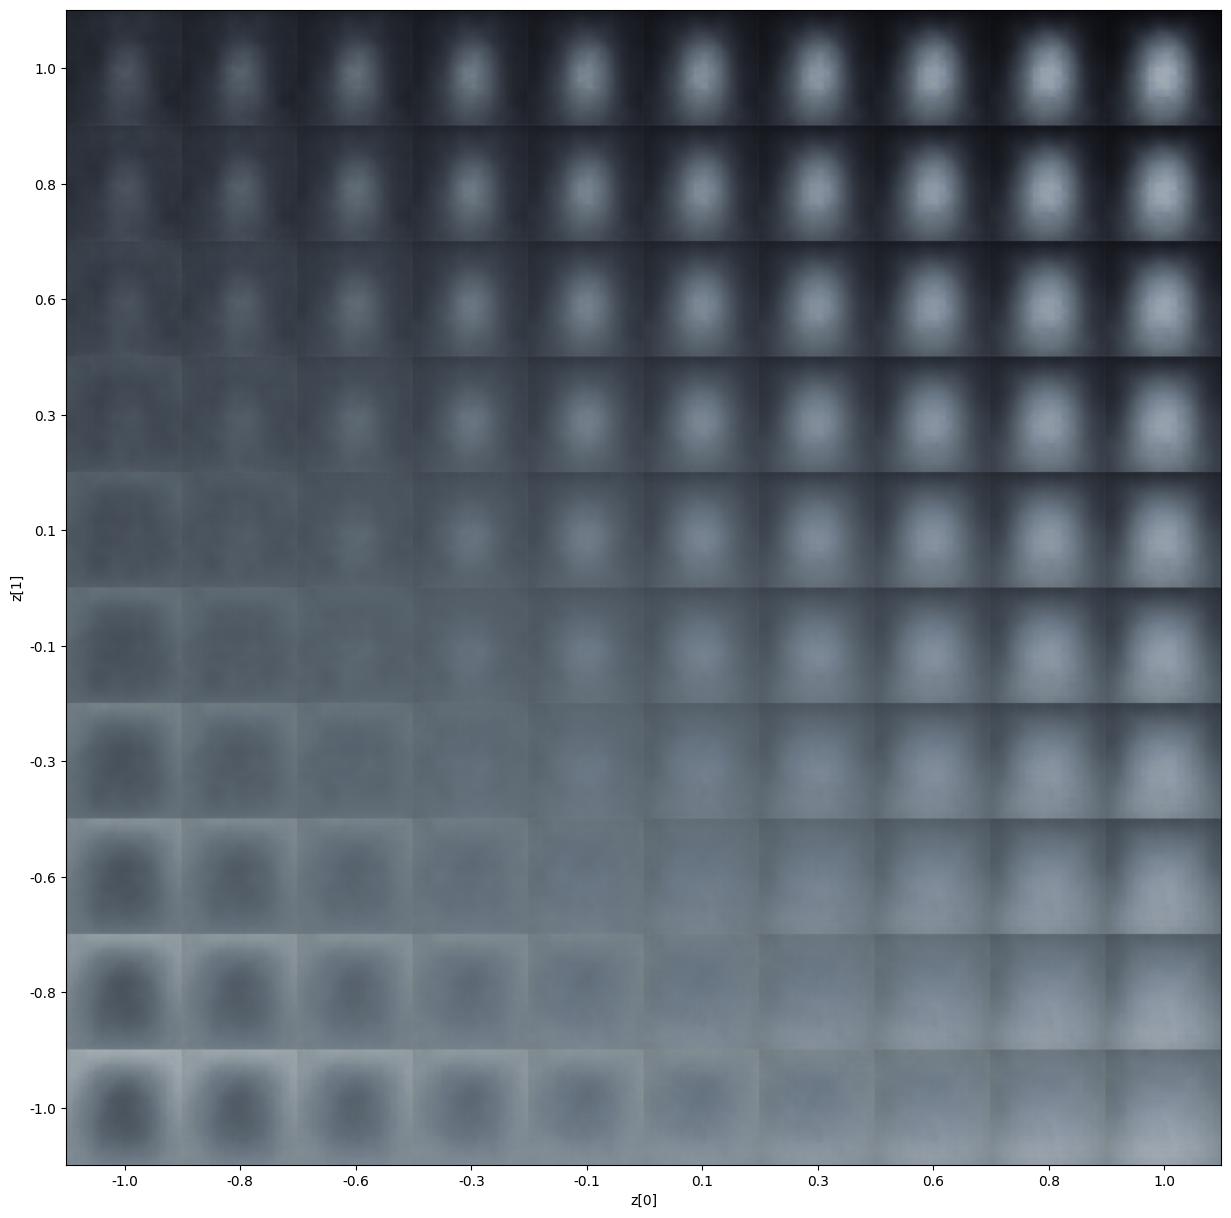

In [18]:
def plot_latent_space(vae, n=10, figsize=15):
    #definindo tamanho das imagens
    digit_size = 64
    #definindo escala do grid de imagens geradas
    scale = 1
    #criando matriz de zeros para armazenar imagens geradas
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    #definindo coordenadas x e y do grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    #loop pra gerar as imagens do grid
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            #criando vetor de coordenadas no espaço latente
            z_sample = np.array([[xi, yi]])
            #gerando imagem a partir do vetor de coordenadas com decodificador da VAE
            x_decoded = vae.decoder.predict(z_sample)
            #selecionando imagem gerada e incluindo-a na matriz de imagens
            digit = x_decoded[0]
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    #plotagem matriz de imagens
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    #arredondando coordenadas para exibição no gráfico
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

#chamando função plot_latent_space, passando a VAE treinada como parâmetro
plot_latent_space(vae)

1/1 [==============================] - 0s 17ms/step


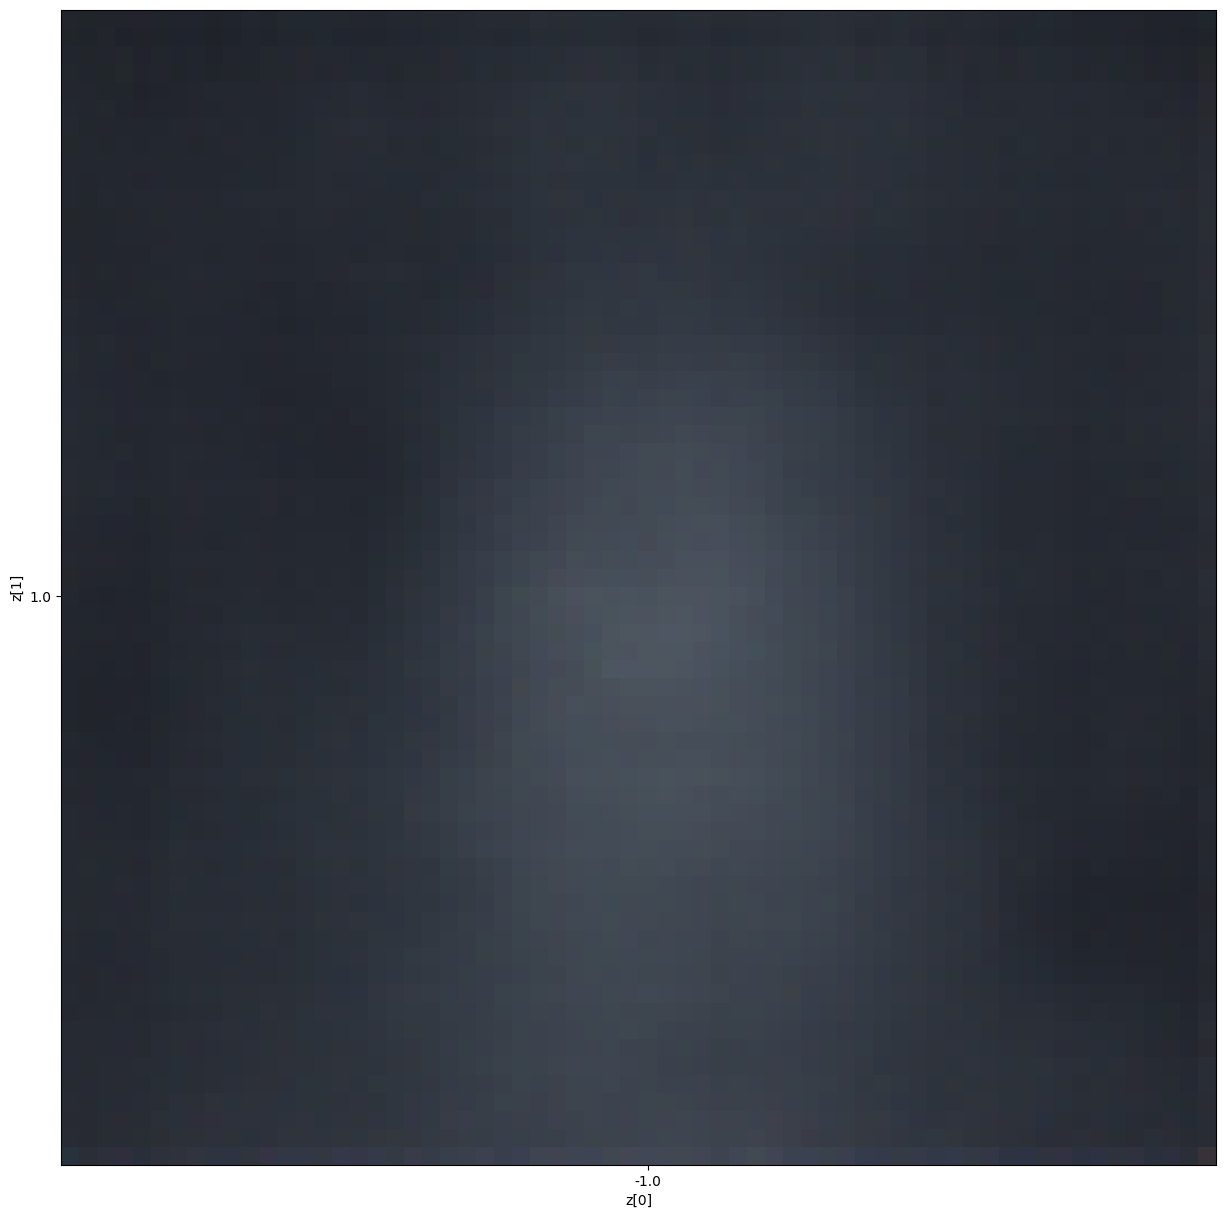

In [20]:
n=10
figsize=15
digit_size = 64
scale = 1
figure = np.zeros((digit_size, digit_size, 3))
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)[::-1]
#valores de z que serão usados para gerar 1ª imagem
z_sample = np.array([[grid_x[0], grid_y[0]]])
#gerando imagem a partir do vetor z_sample usando o decoder da VAE
x_decoded = vae.decoder.predict(z_sample)
digit = x_decoded[0]
#adicionando imagem ao array que será plotado
figure[0 * digit_size : (0 + 1) * digit_size,
       0 * digit_size : (0 + 1) * digit_size,] = digit

#configurando o plot
plt.figure(figsize=(figsize, figsize))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

#plotando o grid de imagens
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure)
plt.show()